# LSTM Multiserie e Multivariada

## Dataset

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

from sklearn.preprocessing import MinMaxScaler

In [2]:
trip = pd.read_csv("./data/ieee/TripA01.csv", sep=";", encoding='unicode_escape')
trip.head()

,Time [s],Velocity [km/h],Elevation [m],Throttle [%],Motor Torque [Nm],Longitudinal Acceleration [m/s^2],Regenerative Braking Signal,Battery Voltage [V],Battery Current [A],Battery Temperature [°C],...,AirCon Power [kW],Heater Signal,Heater Voltage [V],Heater Current [A],Ambient Temperature [°C],Coolant Temperature Heatercore [°C],Requested Coolant Temperature [°C],Coolant Temperature Inlet [°C],Heat Exchanger Temperature [°C],Cabin Temperature Sensor [°C]
0,0.0,0.0,574.0,0.0,0.0,-0.03,0.0,391.4,-2.20,21.0,...,0.4,1,0,0,25.5,0,0,0,30.5,24.5
1,0.1,0.0,574.0,0.0,0.0,0.00,0.0,391.4,-2.21,21.0,...,0.4,1,0,0,25.5,0,0,0,30.5,24.5
2,0.2,0.0,574.0,0.0,0.0,-0.01,0.0,391.4,-2.26,21.0,...,0.4,1,0,0,25.5,0,0,0,30.5,24.5
3,0.3,0.0,574.0,0.0,0.0,-0.03,0.0,391.4,-2.30,21.0,...,0.4,1,0,0,25.5,0,0,0,30.5,24.5
4,0.4,0.0,574.0,0.0,0.0,-0.03,0.0,391.4,-2.30,21.0,...,0.4,1,0,0,25.5,0,0,0,30.5,24.5


In [3]:
trip.columns

Index(['Time [s]', 'Velocity [km/h]', 'Elevation [m]', 'Throttle [%]',
       'Motor Torque [Nm]', 'Longitudinal Acceleration [m/s^2]',
       'Regenerative Braking Signal ', 'Battery Voltage [V]',
       'Battery Current [A]', 'Battery Temperature [°C]',
       'max. Battery Temperature [°C]', 'SoC [%]', 'displayed SoC [%]',
       'min. SoC [%]', 'max. SoC [%)', 'Heating Power CAN [kW]',
       'Heating Power LIN [W]', 'Requested Heating Power [W]',
       'AirCon Power [kW]', 'Heater Signal', 'Heater Voltage [V]',
       'Heater Current [A]', 'Ambient Temperature [°C]',
       'Coolant Temperature Heatercore [°C]',
       'Requested Coolant Temperature [°C]', 'Coolant Temperature Inlet [°C]',
       'Heat Exchanger Temperature [°C]', 'Cabin Temperature Sensor [°C]'],
      dtype='object')

In [4]:
trip.describe()

,Time [s],Velocity [km/h],Elevation [m],Throttle [%],Motor Torque [Nm],Longitudinal Acceleration [m/s^2],Regenerative Braking Signal,Battery Voltage [V],Battery Current [A],Battery Temperature [°C],...,AirCon Power [kW],Heater Signal,Heater Voltage [V],Heater Current [A],Ambient Temperature [°C],Coolant Temperature Heatercore [°C],Requested Coolant Temperature [°C],Coolant Temperature Inlet [°C],Heat Exchanger Temperature [°C],Cabin Temperature Sensor [°C]
count,10090.000000,10090.000000,10090.000000,10090.000000,10090.000000,10090.000000,10090.000000,10090.000000,10090.000000,10090.000000,...,10090.000000,10090.0,10090.0,10090.0,10090.000000,10090.0,10090.0,10090.0,10090.000000,10090.000000
mean,504.450000,26.502170,566.791625,26.470424,8.106545,0.014246,0.118162,388.483996,-11.953476,21.940141,...,1.610408,1.0,0.0,0.0,30.769972,0.0,0.0,0.0,8.589470,23.907057
std,291.287644,15.497032,5.577563,16.370510,42.123984,0.741669,0.322172,2.158318,22.799614,0.237147,...,0.340490,0.0,0.0,0.0,1.619032,0.0,0.0,0.0,7.124407,1.249755
min,0.000000,0.000000,558.000000,0.000000,-87.050000,-2.290000,0.000000,380.420000,-100.700000,21.000000,...,0.400000,1.0,0.0,0.0,25.500000,0.0,0.0,0.0,5.000000,22.170000
25%,252.225000,15.362500,562.090000,13.550000,-9.157500,-0.330000,0.000000,387.190000,-22.197500,22.000000,...,1.580000,1.0,0.0,0.0,30.500000,0.0,0.0,0.0,5.000000,22.670000
50%,504.450000,29.550000,565.000000,31.100000,4.630000,0.020000,0.000000,388.540000,-8.570000,22.000000,...,1.670000,1.0,0.0,0.0,31.000000,0.0,0.0,0.0,5.000000,24.000000
75%,756.675000,38.720000,574.000000,40.357500,23.540000,0.350000,0.000000,390.000000,-1.990000,22.000000,...,1.760000,1.0,0.0,0.0,32.000000,0.0,0.0,0.0,7.000000,25.010000
max,1008.900000,53.300000,574.000000,55.900000,174.420000,2.790000,1.000000,394.470000,66.220000,22.000000,...,2.520000,1.0,0.0,0.0,33.500000,0.0,0.0,0.0,30.500000,25.840000


In [5]:
trip.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10090 entries, 0 to 10089
Data columns (total 28 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Time [s]                             10090 non-null  float64
 1   Velocity [km/h]                      10090 non-null  float64
 2   Elevation [m]                        10090 non-null  float64
 3   Throttle [%]                         10090 non-null  float64
 4   Motor Torque [Nm]                    10090 non-null  float64
 5   Longitudinal Acceleration [m/s^2]    10090 non-null  float64
 6   Regenerative Braking Signal          10090 non-null  float64
 7   Battery Voltage [V]                  10090 non-null  float64
 8   Battery Current [A]                  10090 non-null  float64
 9   Battery Temperature [°C]             10090 non-null  float64
 10  max. Battery Temperature [°C]        10090 non-null  float64
 11  SoC [%]                     

In [6]:
trip = trip.sort_values("Time [s]")
trip.head()

,Time [s],Velocity [km/h],Elevation [m],Throttle [%],Motor Torque [Nm],Longitudinal Acceleration [m/s^2],Regenerative Braking Signal,Battery Voltage [V],Battery Current [A],Battery Temperature [°C],...,AirCon Power [kW],Heater Signal,Heater Voltage [V],Heater Current [A],Ambient Temperature [°C],Coolant Temperature Heatercore [°C],Requested Coolant Temperature [°C],Coolant Temperature Inlet [°C],Heat Exchanger Temperature [°C],Cabin Temperature Sensor [°C]
0,0.0,0.0,574.0,0.0,0.0,-0.03,0.0,391.4,-2.20,21.0,...,0.4,1,0,0,25.5,0,0,0,30.5,24.5
1,0.1,0.0,574.0,0.0,0.0,0.00,0.0,391.4,-2.21,21.0,...,0.4,1,0,0,25.5,0,0,0,30.5,24.5
2,0.2,0.0,574.0,0.0,0.0,-0.01,0.0,391.4,-2.26,21.0,...,0.4,1,0,0,25.5,0,0,0,30.5,24.5
3,0.3,0.0,574.0,0.0,0.0,-0.03,0.0,391.4,-2.30,21.0,...,0.4,1,0,0,25.5,0,0,0,30.5,24.5
4,0.4,0.0,574.0,0.0,0.0,-0.03,0.0,391.4,-2.30,21.0,...,0.4,1,0,0,25.5,0,0,0,30.5,24.5


## Preprocessamento

In [7]:
X = trip.drop(columns=['Time [s]', 'Motor Torque [Nm]']).values
y = trip['Motor Torque [Nm]'].values

In [8]:
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)

## Janelamento e Treinamento do Modelo

In [9]:
def LSTM_model(data, labels, window_size=10, train_size=0.8, epochs=10):
    # Janelando os dados
    X_seq, y_seq = [], []
    
    for i in range(window_size, len(data)):
        X_seq.append(data[i-window_size:i, :])
        y_seq.append(labels[i])
        
    X_seq, y_seq = np.array(X_seq), np.array(y_seq)

    
    # Divisão de treino e teste com 80% para treino e 20% para teste
    train_size = int(len(X_seq) * train_size)
    X_train, X_test = X_seq[:train_size], X_seq[train_size:]
    y_train, y_test = y_seq[:train_size], y_seq[train_size:]


    # Criando e treinando o modelo
    model = Sequential(
        [
            LSTM(32, activation='tanh', input_shape=(1, X_train.shape[2])),
            Dense(32, activation='relu'), 
            Dense(1) 
        ]
    )

    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=16)


    # Imprimindo a avaliação
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Épocas')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid()

    loss, mae = model.evaluate(X_test, y_test)
    print(f"MAE: {mae:.8f}, Loss: {loss:.8f}")

    return model

In [15]:
model = LSTM_model(X_scaled, y, window_size=10, train_size=0.8, epochs=20)

Epoch 1/20


E0000 00:00:1744037004.596823   54120 cuda_dnn.cc:522] Loaded runtime CuDNN library: 9.1.0 but source was compiled with: 9.3.0.  CuDNN library needs to have matching major version and equal or higher minor version. If using a binary install, upgrade your CuDNN library.  If building from sources, make sure the library loaded at runtime is compatible with the version specified during compile configuration.
2025-04-07 11:43:24.597340: W tensorflow/core/framework/op_kernel.cc:1857] OP_REQUIRES failed at cudnn_rnn_ops.cc:1769 : INVALID_ARGUMENT: Dnn is not supported
2025-04-07 11:43:24.597364: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: INVALID_ARGUMENT: Dnn is not supported
	 [[{{function_node __inference_one_step_on_data_3661}}{{node sequential_1_1/lstm_1_1/CudnnRNNV3}}]]


InvalidArgumentError: Graph execution error:

Detected at node sequential_1_1/lstm_1_1/CudnnRNNV3 defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/home/andre/venv/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/home/andre/venv/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/andre/venv/lib/python3.12/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/andre/venv/lib/python3.12/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.12/asyncio/base_events.py", line 641, in run_forever

  File "/usr/lib/python3.12/asyncio/base_events.py", line 1987, in _run_once

  File "/usr/lib/python3.12/asyncio/events.py", line 88, in _run

  File "/home/andre/venv/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/home/andre/venv/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/home/andre/venv/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/home/andre/venv/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/home/andre/venv/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/home/andre/venv/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/home/andre/venv/lib/python3.12/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/andre/venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/home/andre/venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/home/andre/venv/lib/python3.12/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/home/andre/venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/home/andre/venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/home/andre/venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/tmp/ipykernel_53981/1254553619.py", line 1, in <module>

  File "/tmp/ipykernel_53981/1743565508.py", line 29, in LSTM_model

  File "/home/andre/venv/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/andre/venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 368, in fit

  File "/home/andre/venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 216, in function

  File "/home/andre/venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 129, in multi_step_on_iterator

  File "/home/andre/venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 110, in one_step_on_data

  File "/home/andre/venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 56, in train_step

  File "/home/andre/venv/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/andre/venv/lib/python3.12/site-packages/keras/src/layers/layer.py", line 899, in __call__

  File "/home/andre/venv/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/andre/venv/lib/python3.12/site-packages/keras/src/ops/operation.py", line 46, in __call__

  File "/home/andre/venv/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/home/andre/venv/lib/python3.12/site-packages/keras/src/models/sequential.py", line 213, in call

  File "/home/andre/venv/lib/python3.12/site-packages/keras/src/models/functional.py", line 182, in call

  File "/home/andre/venv/lib/python3.12/site-packages/keras/src/ops/function.py", line 171, in _run_through_graph

  File "/home/andre/venv/lib/python3.12/site-packages/keras/src/models/functional.py", line 632, in call

  File "/home/andre/venv/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/andre/venv/lib/python3.12/site-packages/keras/src/layers/layer.py", line 899, in __call__

  File "/home/andre/venv/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/andre/venv/lib/python3.12/site-packages/keras/src/ops/operation.py", line 46, in __call__

  File "/home/andre/venv/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/home/andre/venv/lib/python3.12/site-packages/keras/src/layers/rnn/lstm.py", line 570, in call

  File "/home/andre/venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py", line 402, in call

  File "/home/andre/venv/lib/python3.12/site-packages/keras/src/layers/rnn/lstm.py", line 537, in inner_loop

  File "/home/andre/venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/rnn.py", line 841, in lstm

  File "/home/andre/venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/rnn.py", line 933, in _cudnn_lstm

Dnn is not supported
	 [[{{node sequential_1_1/lstm_1_1/CudnnRNNV3}}]] [Op:__inference_multi_step_on_iterator_3720]

## Treinamento e Avaliação do Modelo com N series

### Preparação do Dataset

In [1]:
import os
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

2025-04-07 11:18:03.651807: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-07 11:18:03.666898: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744035483.676135   49674 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744035483.678982   49674 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744035483.686858   49674 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
directory = "./data/ieee/"
files = os.listdir(directory)
files.sort()

trips = []
for file in files:
    trip = pd.read_csv(directory + file, sep=";", encoding='unicode_escape')
    trip = trip.sort_values(by='Time [s]')
    trip['Trip'] = file.split(".")[0]
    trips.append(trip)

columns = []
for trip in trips:
    if 'Velocity [km/h]]]' in trip.columns:
        trip = trip.rename(columns={'Velocity [km/h]]]': 'Velocity [km/h]'})
        print(trip['Trip'].unique())
    columns.append(trip.columns.tolist())

grupo_colunas_unicos = [list(x) for x in set(tuple(lst) for lst in columns)]
grupo_colunas_unicos

['TripB38']


[['Time [s]',
  'Velocity [km/h]',
  'Elevation [m]',
  'Throttle [%]',
  'Motor Torque [Nm]',
  'Longitudinal Acceleration [m/s^2]',
  'Regenerative Braking Signal ',
  'Battery Voltage [V]',
  'Battery Current [A]',
  'Battery Temperature [°C]',
  'max. Battery Temperature [°C]',
  'SoC [%]',
  'displayed SoC [%]',
  'min. SoC [%]',
  'max. SoC [%)',
  'Heating Power CAN [kW]',
  'Heating Power LIN [W]',
  'Requested Heating Power [W]',
  'AirCon Power [kW]',
  'Heater Signal',
  'Heater Voltage [V]',
  'Heater Current [A]',
  'Ambient Temperature [°C]',
  'Ambient Temperature Sensor [°C]',
  'Coolant Temperature Heatercore [°C]',
  'Requested Coolant Temperature [°C]',
  'Coolant Temperature Inlet [°C]',
  'Coolant Volume Flow +500 [l/h]',
  'Heat Exchanger Temperature [°C]',
  'Cabin Temperature Sensor [°C]',
  'Temperature Coolant Heater Inlet [°C]',
  'Temperature Coolant Heater Outlet [°C]',
  'Temperature Heat Exchanger Outlet [°C]',
  'Temperature Defrost lateral left [°C]',
 

In [3]:
total_columns = grupo_colunas_unicos[0]

for group in grupo_colunas_unicos:
    for column in group:
        if column not in total_columns:
            total_columns.append(column)

print(len(total_columns))
total_columns.sort()
total_columns

50


['AirCon Power [kW]',
 'Ambient Temperature Sensor [°C]',
 'Ambient Temperature [°C]',
 'Battery Current [A]',
 'Battery Temperature [°C]',
 'Battery Voltage [V]',
 'Cabin Temperature Sensor [°C]',
 'Coolant Temperature Heatercore [°C]',
 'Coolant Temperature Inlet [°C]',
 'Coolant Volume Flow +500 [l/h]',
 'Elevation [m]',
 'Heat Exchanger Temperature [°C]',
 'Heater Current [A]',
 'Heater Signal',
 'Heater Voltage [V]',
 'Heating Power CAN [kW]',
 'Heating Power LIN [W]',
 'Longitudinal Acceleration [m/s^2]',
 'Motor Torque [Nm]',
 'Regenerative Braking Signal ',
 'Requested Coolant Temperature [°C]',
 'Requested Heating Power [W]',
 'SoC [%]',
 'Temperature Coolant Heater Inlet [°C]',
 'Temperature Coolant Heater Outlet [°C]',
 'Temperature Defrost central [°C]',
 'Temperature Defrost central left [°C]',
 'Temperature Defrost central right [°C]',
 'Temperature Defrost lateral left [°C]',
 'Temperature Defrost lateral right [°C]',
 'Temperature Feetvent Co-Driver [°C]',
 'Temperature

In [4]:
colunas_comuns = set(grupo_colunas_unicos[0])

for item in grupo_colunas_unicos[1:]:
    colunas_comuns.intersection_update(item)

colunas_comuns = list(colunas_comuns)
colunas_comuns.sort()
colunas_comuns

['AirCon Power [kW]',
 'Ambient Temperature [°C]',
 'Battery Current [A]',
 'Battery Temperature [°C]',
 'Battery Voltage [V]',
 'Cabin Temperature Sensor [°C]',
 'Elevation [m]',
 'Heat Exchanger Temperature [°C]',
 'Heater Signal',
 'Heating Power CAN [kW]',
 'Longitudinal Acceleration [m/s^2]',
 'Motor Torque [Nm]',
 'Regenerative Braking Signal ',
 'Requested Heating Power [W]',
 'SoC [%]',
 'Throttle [%]',
 'Time [s]',
 'Trip',
 'Velocity [km/h]',
 'displayed SoC [%]',
 'max. Battery Temperature [°C]',
 'max. SoC [%)',
 'min. SoC [%]']

In [5]:
colunas_remover = [
    'Battery Current [A]',
    'Battery Temperature [°C]',
    'Battery Voltage [V]',
    'Regenerative Braking Signal ',
    'SoC [%]',
    'displayed SoC [%]',
    'max. Battery Temperature [°C]',
    'max. SoC [%)',
    'min. SoC [%]'
]

colunas_final = [item for item in colunas_comuns if item not in colunas_remover]
colunas_final.sort()
colunas_final

['AirCon Power [kW]',
 'Ambient Temperature [°C]',
 'Cabin Temperature Sensor [°C]',
 'Elevation [m]',
 'Heat Exchanger Temperature [°C]',
 'Heater Signal',
 'Heating Power CAN [kW]',
 'Longitudinal Acceleration [m/s^2]',
 'Motor Torque [Nm]',
 'Requested Heating Power [W]',
 'Throttle [%]',
 'Time [s]',
 'Trip',
 'Velocity [km/h]']

In [6]:
trips = pd.concat(trips)
trips = trips[colunas_final]
trips.shape

(1094793, 14)

In [7]:
trips['Trip'].unique()

array(['TripA01', 'TripA02', 'TripA03', 'TripA04', 'TripA05', 'TripA06',
       'TripA07', 'TripA08', 'TripA09', 'TripA10', 'TripA11', 'TripA12',
       'TripA13', 'TripA14', 'TripA15', 'TripA16', 'TripA17', 'TripA18',
       'TripA19', 'TripA20', 'TripA21', 'TripA22', 'TripA23', 'TripA24',
       'TripA25', 'TripA26', 'TripA27', 'TripA28', 'TripA29', 'TripA30',
       'TripA31', 'TripA32', 'TripB01', 'TripB02', 'TripB03', 'TripB04',
       'TripB05', 'TripB06', 'TripB07', 'TripB08', 'TripB09', 'TripB10',
       'TripB11', 'TripB12', 'TripB13', 'TripB14', 'TripB15', 'TripB16',
       'TripB17', 'TripB18', 'TripB19', 'TripB20', 'TripB21', 'TripB22',
       'TripB23', 'TripB24', 'TripB25', 'TripB26', 'TripB27', 'TripB28',
       'TripB29', 'TripB30', 'TripB31', 'TripB32', 'TripB33', 'TripB34',
       'TripB35', 'TripB36', 'TripB37', 'TripB38'], dtype=object)

In [8]:
X = trips.drop(columns=['Time [s]', 'Motor Torque [Nm]', 'Trip'])
y = trips['Motor Torque [Nm]'].values

In [9]:
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X.values)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

In [10]:
X_scaled = pd.DataFrame(
    X_scaled,
    columns=X.columns,
    index=X.index
)
X_scaled['Trip'] = trips['Trip']
X_scaled.head()

,AirCon Power [kW],Ambient Temperature [°C],Cabin Temperature Sensor [°C],Elevation [m],Heat Exchanger Temperature [°C],Heater Signal,Heating Power CAN [kW],Longitudinal Acceleration [m/s^2],Requested Heating Power [W],Throttle [%],Velocity [km/h],Trip
0,0.163324,0.783784,0.485904,0.600904,0.424646,1.0,0.0,0.667161,0.002206,0.0,0.0,TripA01
1,0.163324,0.783784,0.485904,0.600904,0.424646,1.0,0.0,0.669385,0.002206,0.0,0.0,TripA01
2,0.163324,0.783784,0.485904,0.600904,0.424646,1.0,0.0,0.668643,0.002206,0.0,0.0,TripA01
3,0.163324,0.783784,0.485904,0.600904,0.424646,1.0,0.0,0.667161,0.002206,0.0,0.0,TripA01
4,0.163324,0.783784,0.485904,0.600904,0.424646,1.0,0.0,0.667161,0.002206,0.0,0.0,TripA01


In [11]:
scaled_dataset = X_scaled
scaled_dataset['Motor Torque [Nm]'] = y_scaled
scaled_dataset.head()

,AirCon Power [kW],Ambient Temperature [°C],Cabin Temperature Sensor [°C],Elevation [m],Heat Exchanger Temperature [°C],Heater Signal,Heating Power CAN [kW],Longitudinal Acceleration [m/s^2],Requested Heating Power [W],Throttle [%],Velocity [km/h],Trip,Motor Torque [Nm]
0,0.163324,0.783784,0.485904,0.600904,0.424646,1.0,0.0,0.667161,0.002206,0.0,0.0,TripA01,0.260522
1,0.163324,0.783784,0.485904,0.600904,0.424646,1.0,0.0,0.669385,0.002206,0.0,0.0,TripA01,0.260522
2,0.163324,0.783784,0.485904,0.600904,0.424646,1.0,0.0,0.668643,0.002206,0.0,0.0,TripA01,0.260522
3,0.163324,0.783784,0.485904,0.600904,0.424646,1.0,0.0,0.667161,0.002206,0.0,0.0,TripA01,0.260522
4,0.163324,0.783784,0.485904,0.600904,0.424646,1.0,0.0,0.667161,0.002206,0.0,0.0,TripA01,0.260522


In [12]:
def time_series_train_test_split(dataset, train_size=0.8):
    X_trains, X_tests, y_trains, y_tests = [], [], [], []
    
    for trip in dataset['Trip'].unique():
        data_slice = dataset[dataset['Trip'] == trip]
        size = int(len(data_slice) * train_size)
    
        X_trains.append(data_slice.iloc[:size, :-1])
        X_tests.append(data_slice.iloc[size:, :-1])
        
        y_trains.append(data_slice.iloc[:size, -1])
        y_tests.append(data_slice.iloc[size:, -1])
    
    return pd.concat(X_trains), pd.concat(X_tests), pd.concat(y_trains), pd.concat(y_tests)

X_train, X_test, y_train, y_test = time_series_train_test_split(scaled_dataset)

In [13]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(875810, 12)
(218983, 12)
(875810,)
(218983,)


In [14]:
def create_seq(X, y, window_size=10):
    X_seq, y_seq = [], []
    
    for i in range(window_size, len(X)):
        data_slice = X.iloc[i-window_size:i, :]

        # Se tiver mais de uma trip na mesma janela, eu não adiciono no conjunto de dados
        if len(data_slice['Trip'].unique()) == 1:
            X_seq.append(data_slice.drop(columns=['Trip']).values)
            y_seq.append(y[i])
        
    return np.array(X_seq), np.array(y_seq)


X_train_seq, y_train_seq = create_seq(X_train, y_train.values, window_size=10)
X_test_seq, y_test_seq = create_seq(X_test, y_test.values, window_size=10)

In [15]:
X_train_seq.tofile('./X_train_seq.dat')
y_train_seq.tofile('./y_train_seq.dat')
X_test_seq.tofile('./X_test_seq.dat')
y_test_seq.tofile('./y_test_seq.dat')

In [3]:
X_train_seq = np.fromfile('./X_train_seq.dat')
y_train_seq = np.fromfile('./y_train_seq.dat')
X_test_seq = np.fromfile('./X_test_seq.dat')
y_test_seq = np.fromfile('./y_test_seq.dat')

### Treinamento do LSTM

In [4]:
def LSTM_model(X_seq, y_seq, window_size=10, train_size=0.8, epochs=10):
    # Divisão de treino e validação com 80% para treino e 20% para validação
    train_size = int(len(X_seq) * train_size)
    X_train, X_test = X_seq[:train_size], X_seq[train_size:]
    y_train, y_test = y_seq[:train_size], y_seq[train_size:]


    # Criando e treinando o modelo
    model = Sequential(
        [
            LSTM(32, activation='tanh', input_shape=(1, X_train.shape[2])),
            Dense(32, activation='relu'), 
            Dense(1) 
        ]
    )

    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=16)


    # Imprimindo a avaliação
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Épocas')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid()

    loss, mae = model.evaluate(X_test, y_test)
    print(f"MAE: {mae:.8f}, Loss: {loss:.8f}")

    return model

In [5]:
model = LSTM_model(X_train_seq, y_train_seq, window_size=10, train_size=0.8, epochs=3)
model

IndexError: tuple index out of range

In [21]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 32)             │        10,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,373 (134.27 KB)

 Trainable params: 11,457 (44.75 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 22,916 (89.52 KB)

### Avaliação 

In [22]:
def plot_error_histogram(y_pred, y_test):
    # Erro é o predito menos o real
    error = y_pred - y_test

    # Estatísticas do erro
    mean_error = np.mean(error)
    std_error = np.std(error)
    min_error = np.min(error)
    max_error = np.max(error)

    # Histograma
    plt.hist(error, bins=30, color='blue', alpha=0.7, edgecolor='black')

    # Linhas de referência
    plt.axvline(mean_error, color='red', linestyle='dashed', linewidth=2, label=f"Média: {mean_error:.4f}")
    plt.axvline(mean_error + 2*std_error, color='green', linestyle='dashed', linewidth=2, label=f'+2σ: {(mean_error + 2*std_error):.4f}')
    plt.axvline(mean_error - 2*std_error, color='green', linestyle='dashed', linewidth=2, label=f'-2σ: {(mean_error - 2*std_error):.4f}')
    plt.axvline(min_error, color='purple', linestyle='dashed', linewidth=2, label=f'Mínimo: {min_error:.4f}')
    plt.axvline(max_error, color='orange', linestyle='dashed', linewidth=2, label=f'Máximo: {max_error:.4f}')

    # Extras
    plt.xlabel("Erro (y_pred - y_real)")
    plt.ylabel("Frequência")
    plt.legend()
    plt.grid(True)

    plt.show()

6824/6824 ━━━━━━━━━━━━━━━━━━━━ 3s 472us/step


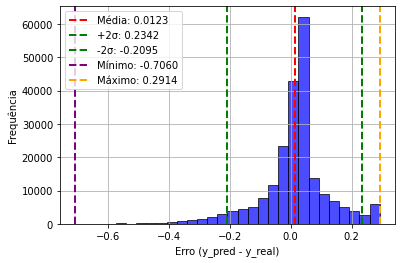

In [26]:
prediction = model.predict(X_test_seq)
y_pred_seq = prediction.reshape(1,-1)[0]

plot_error_histogram(y_pred_seq, y_test_seq)